# Future Investment Value Prediction Model

## Goal
- Estimate how much a user’s investments will grow over time, taking into account factors like investment type, expected ROI, and inflation

## Model
- Gradient Boosting (LightGBM or XGBoost)

## Inputs
- Total_Invested_Amount, Expected_ROI, Retirement_Age, Age, Inflation_Rate, Savings_Rate, Cost_of_Living

## Target
- Future_Investment_Value=Total Invested Amount*(1+Expected_ROI)^(Retirement_Age−Age)

## Imports

In [412]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import os
import json

In [413]:
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/My Drive/NTU/NTU OSS Project/data_final.csv")
df.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             50000 non-null  float64
 1   Education_Level                 50000 non-null  object 
 2   Occupation                      50000 non-null  object 
 3   Number_of_Dependents            50000 non-null  float64
 4   Location                        50000 non-null  object 
 5   Work_Experience                 50000 non-null  float64
 6   Marital_Status                  50000 non-null  object 
 7   Employment_Status               50000 non-null  object 
 8   Household_Size                  50000 non-null  float64
 9   Homeownership_Status            50000 non-null  object 
 10  Type_of_Housing          

# Data Cleaning

## Check for Logical Consistency
- Check for negative/invalid values: Ensure that all monetary values are non-negative
- Check if Expected_ROI is realistic (eg between 0-20%)
- Ensure Retirement_Age > Age

In [414]:
print(df.isna().sum())

Age                               0
Education_Level                   0
Occupation                        0
Number_of_Dependents              0
Location                          0
Work_Experience                   0
Marital_Status                    0
Employment_Status                 0
Household_Size                    0
Homeownership_Status              0
Type_of_Housing                   0
Gender                            0
Primary_Mode_of_Transportation    0
Income                            0
Career_Level                      0
Financial_Status                  0
Housing                           0
Food                              0
Transportation                    0
Education                         0
Total_Invested_Amount             0
Emergency_Funds                   0
Tax_Rate                          0
Cost_of_Living                    0
Monthly_Savings                   0
Income_Growth_Rate                0
Budget_Adjustments                0
Expected_ROI                

In [415]:
# extract all monetary columns
monetary_col = ["Income", "Housing", "Food", "Transportation", "Education", "Total_Invested_Amount", "Emergency_Funds", "Cost_of_Living", "Monthly_Savings", "Budget_Adjustments", "Healthcare_Cost", "Debt", "Desired_Expenses"]
monetary_df = df[monetary_col]

In [416]:
# Identify columns with and without negative values
columns_with_negative = {col: monetary_df[col].lt(0).sum() for col in monetary_df.columns if monetary_df[col].lt(0).any()}
columns_without_negative = [col for col in monetary_df.columns if col not in columns_with_negative]

# Print columns with negative values and their counts
if columns_with_negative:
    print("Columns with negative values and counts:")
    for col, count in columns_with_negative.items():
        print(f"- {col}: {count} negative values")

# Print columns without negative values
if columns_without_negative:
    print("\nColumns without negative values:")
    for col in columns_without_negative:
        print(f"- {col}")

Columns with negative values and counts:
- Income: 28 negative values
- Food: 33 negative values
- Education: 3292 negative values
- Total_Invested_Amount: 777 negative values
- Emergency_Funds: 7 negative values
- Cost_of_Living: 246 negative values
- Monthly_Savings: 301 negative values
- Healthcare_Cost: 221 negative values
- Debt: 459 negative values
- Desired_Expenses: 66 negative values

Columns without negative values:
- Housing
- Transportation
- Budget_Adjustments


In [417]:
df = df[(df[monetary_col] >= 0).all(axis=1)]
df.shape

(44869, 35)

In [418]:
# Handle missing values
df = df.copy()
df.fillna({
    'Total_Invested_Amount': df['Total_Invested_Amount'].median(),
    'Expected_ROI': df['Expected_ROI'].mean(),
    'Retirement_Age': 65,
    'Age': df['Age'].median(),
    'Inflation_Rate': 0.025,
    'Savings_Rate': df['Savings_Rate'].median(),
    'Cost_of_Living': df['Cost_of_Living'].median()
}, inplace=True)

In [419]:
# Ensure valid values
df['Expected_ROI'] = df['Expected_ROI'].clip(0, 0.2)

# Filter rows where Retirement_Age <= Age
df = df[df['Retirement_Age'] > df['Age']]

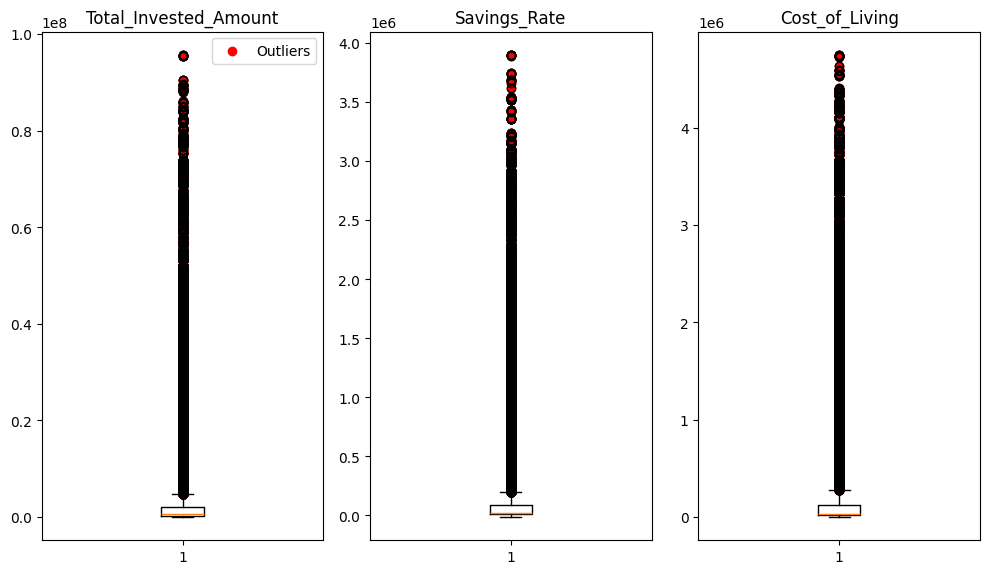

In [420]:
# Detect outliers in Total_Invested_Amount, Savings_Rate and Cost_of_Living using IQR
def plot_boxplot_with_iqr(dataframe, columns):
    plt.figure(figsize=(10, 6))

    for i, col in enumerate(columns, 1):
        # Calculate Q1, Q3, and IQR
        Q1 = dataframe[col].quantile(0.25)
        Q3 = dataframe[col].quantile(0.75)
        IQR = Q3 - Q1

        # Determine outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = dataframe[(dataframe[col] < lower_bound) | (dataframe[col] > upper_bound)]

        # Plot boxplot
        plt.subplot(1, len(columns), i)
        plt.boxplot(dataframe[col], vert=True)
        plt.title(col)
        plt.scatter([1] * len(outliers), outliers[col], color='red', label='Outliers')
        plt.xlabel('')

        if i == 1:
            plt.legend()

    plt.tight_layout()
    plt.show()

columns_to_plot = ['Total_Invested_Amount', 'Savings_Rate', 'Cost_of_Living']
plot_boxplot_with_iqr(df, columns_to_plot)

In [421]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out rows outside the bounds
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

float_columns = df.select_dtypes(include=['float64']).columns

print("Size of dataframe before removal of outliers:", df.shape)

# Apply outlier removal for all float columns
for col in float_columns:
    df = remove_outliers(df, col)

print("Size of dataframe after removing outliers:", df.shape)

Size of dataframe before removal of outliers: (38529, 35)
Size of dataframe after removing outliers: (21355, 35)


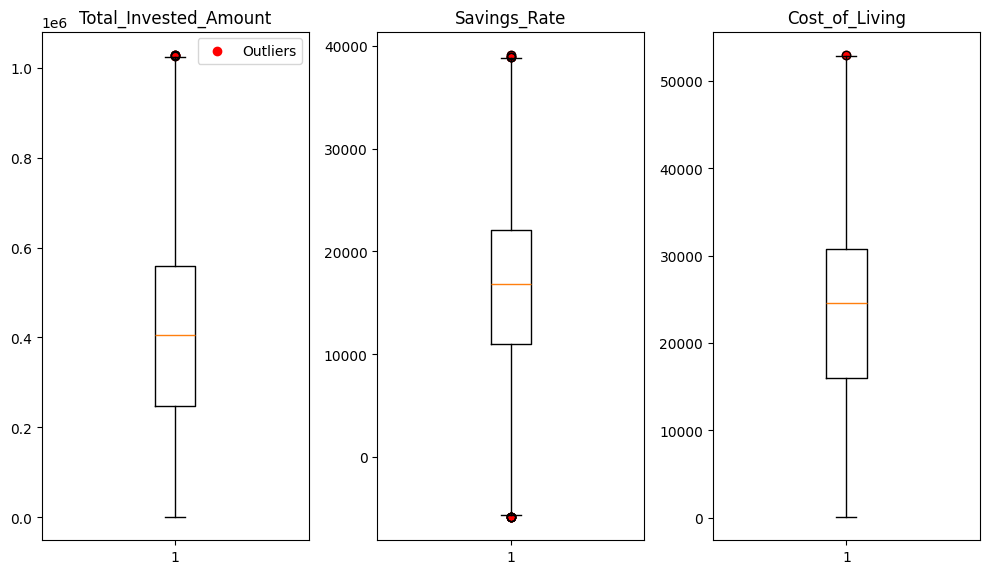

In [422]:
# Plot the boxplots again
plot_boxplot_with_iqr(df, columns_to_plot)

## Feature Engineering
- Years_to_Retirement = Retirement_Age - Age.
- Real_Return_Rate: Adjust ROI for inflation as Expected_ROI - Inflation_Rate.
- Annual_Investment_Growth = Total_Invested_Amount * Expected_ROI
- Normalize or scale continuous features for smoother gradient boosting performance.
- Encode categorical data if any (e.g., investment types)

In [423]:
# Feature Engineering
df['Years_to_Retirement'] = df['Retirement_Age'] - df['Age']
df['Real_Return_Rate'] = df['Expected_ROI'] - df['Inflation_Rate']
df['Annual_Investment_Growth'] = df['Total_Invested_Amount'] * df['Expected_ROI']
df['Future_Investment_Value'] = df['Total_Invested_Amount'] * ((1 + df['Real_Return_Rate']).clip(lower=0.01) ** df['Years_to_Retirement'])
df['Savings_Years_Interaction'] = df['Savings_Rate'] * df['Years_to_Retirement']
df.head()

,Age,Education_Level,Occupation,Number_of_Dependents,Location,Work_Experience,Marital_Status,Employment_Status,Household_Size,Homeownership_Status,...,Savings_Rate,Desired_Expenses,Inflation_Rate,Retirement_Age,Life_Expectancy,Years_to_Retirement,Real_Return_Rate,Annual_Investment_Growth,Future_Investment_Value,Savings_Years_Interaction
0,56.0,Master's,Technology,5.0,Urban,21.0,Married,Full-time,7.0,Own,...,28457.33,24527.93,2.35,63.0,84.0,7.0,-2.15,125335.066,6.266753e-09,199201.31
2,46.0,Bachelor's,Technology,1.0,Urban,1.0,Single,Full-time,7.0,Own,...,22181.83,33326.02,2.35,63.0,83.0,17.0,-2.15,142712.294,7.135615e-29,377091.11
3,32.0,High School,Others,2.0,Urban,32.0,Married,Full-time,1.0,Own,...,11428.21,42327.27,2.35,63.0,83.0,31.0,-2.15,70500.784,3.525039e-57,354274.51
5,25.0,High School,Others,1.0,Rural,6.0,Single,Part-time,1.0,Rent,...,6376.20,51353.34,2.35,63.0,84.0,38.0,-2.15,71438.418,3.571921e-71,242295.60
7,56.0,Master's,Education,1.0,Suburban,34.0,Married,Part-time,7.0,Own,...,21714.28,21311.28,2.35,63.0,84.0,7.0,-2.15,139436.114,6.971806e-09,151999.96


# Model Training
LightBGM
- learning_rate: Controls the step size at each iteration.
- num_leaves: Maximum number of leaves per tree.
- n_estimators: Number of boosting rounds.
- max_depth: Maximum depth of the tree.
- min_data_in_leaf: Minimum number of samples in a leaf.
- feature_fraction: Fraction of features used for training each tree.

## Model 1
- Trained using data set cleaned by removing outliers from all numerical features
- Categorical data is encoded using one hot encoder
- Trained model on 31 features

In [424]:
# Encode categorical data
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_features = df.select_dtypes(include=['object']).columns

# Perform encoding and ensure compatibility
categorical_encoded = encoder.fit_transform(df[categorical_features])
categorical_encoded_df = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out(categorical_features))

# Concatenate the encoded features back to the DataFrame
df_cleaned = pd.concat([df.reset_index(drop=True), categorical_encoded_df.reset_index(drop=True)], axis=1)
df_cleaned.drop(columns=categorical_features, inplace=True)
df_cleaned.head()

,Age,Number_of_Dependents,Work_Experience,Household_Size,Income,Housing,Food,Transportation,Education,Total_Invested_Amount,...,Primary_Mode_of_Transportation_Biking,Primary_Mode_of_Transportation_Car,Primary_Mode_of_Transportation_Public transit,Primary_Mode_of_Transportation_Walking,Career_Level_Entry-Level,Career_Level_Late-Career,Career_Level_Mid-Career,Financial_Status_High Income,Financial_Status_Low Income,Financial_Status_Middle Income
0,56.0,5.0,21.0,7.0,72510.0,2356.29,10497.31,296.32,2400.02,626675.33,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,46.0,1.0,1.0,7.0,71748.0,1019.15,10457.86,664.89,1344.88,713561.47,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,32.0,2.0,32.0,1.0,74520.0,3420.17,9961.84,754.01,1717.72,352503.92,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,25.0,1.0,6.0,1.0,73406.0,2562.41,8397.15,171.85,2119.06,357192.09,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,56.0,1.0,34.0,7.0,70066.0,1053.71,7966.68,86.46,1087.77,697180.57,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [425]:
features = df_cleaned.drop(columns=['Future_Investment_Value']).columns.tolist()
target = 'Future_Investment_Value'
X = df_cleaned[features]
y = df_cleaned[target]

# Normalize features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=features)
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [426]:
# Train-test split (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

params = {
    'learning_rate': 0.01,
    'max_depth': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_estimators': 200,
    'subsample': 0.8,    # Subsampling for better generalization
    'colsample_bytree': 0.8,  # Feature fraction for each tree
}

# Train final model using LightGBM
lgb_model_1 = lgb.LGBMRegressor(**params, objective='regression', random_state=42, n_jobs=-1)
lgb_model_1.fit(X_train, y_train)

# Evaluate model (remains the same)
y_pred = lgb_model_1.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results (remains the same)
print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'R^2 Score: {r2:.4f}')

Mean Squared Error: 57864068.1949
Mean Absolute Error: 790.2190
R^2 Score: 0.9355


# Model 2
- Train model on `11 features`

In [427]:
features = ['Total_Invested_Amount', 'Expected_ROI', 'Retirement_Age', 'Age', 'Inflation_Rate',
            'Savings_Rate', 'Cost_of_Living', 'Years_to_Retirement', 'Real_Return_Rate',
            'Annual_Investment_Growth', 'Savings_Years_Interaction']
target = 'Future_Investment_Value'
X = df[features]
y = df[target]

# Normalize features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=features)
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [428]:
# Train-test split (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

params = {
    'learning_rate': 0.01,
    'max_depth': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_estimators': 200,
    'subsample': 0.8,    # Subsampling for better generalization
    'colsample_bytree': 0.8,  # Feature fraction for each tree
}

# Train final model using LightGBM
lgb_model_2 = lgb.LGBMRegressor(**params, objective='regression', random_state=42, n_jobs=-1)
lgb_model_2.fit(X_train, y_train)

# Evaluate model (remains the same)
y_pred = lgb_model_2.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results (remains the same)
print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'R^2 Score: {r2:.4f}')

Mean Squared Error: 56545539.9402
Mean Absolute Error: 799.2287
R^2 Score: 0.9370


### Interpretation
- Good Fit: The high R-squared value `0.9370` suggests that the model `fits the data well` and `captures the relationships` between the features and the target variable effectively.
- Potential Outliers or Large Errors: The `high MSE` value indicates that there might be some predictions with relatively `large outliers`.

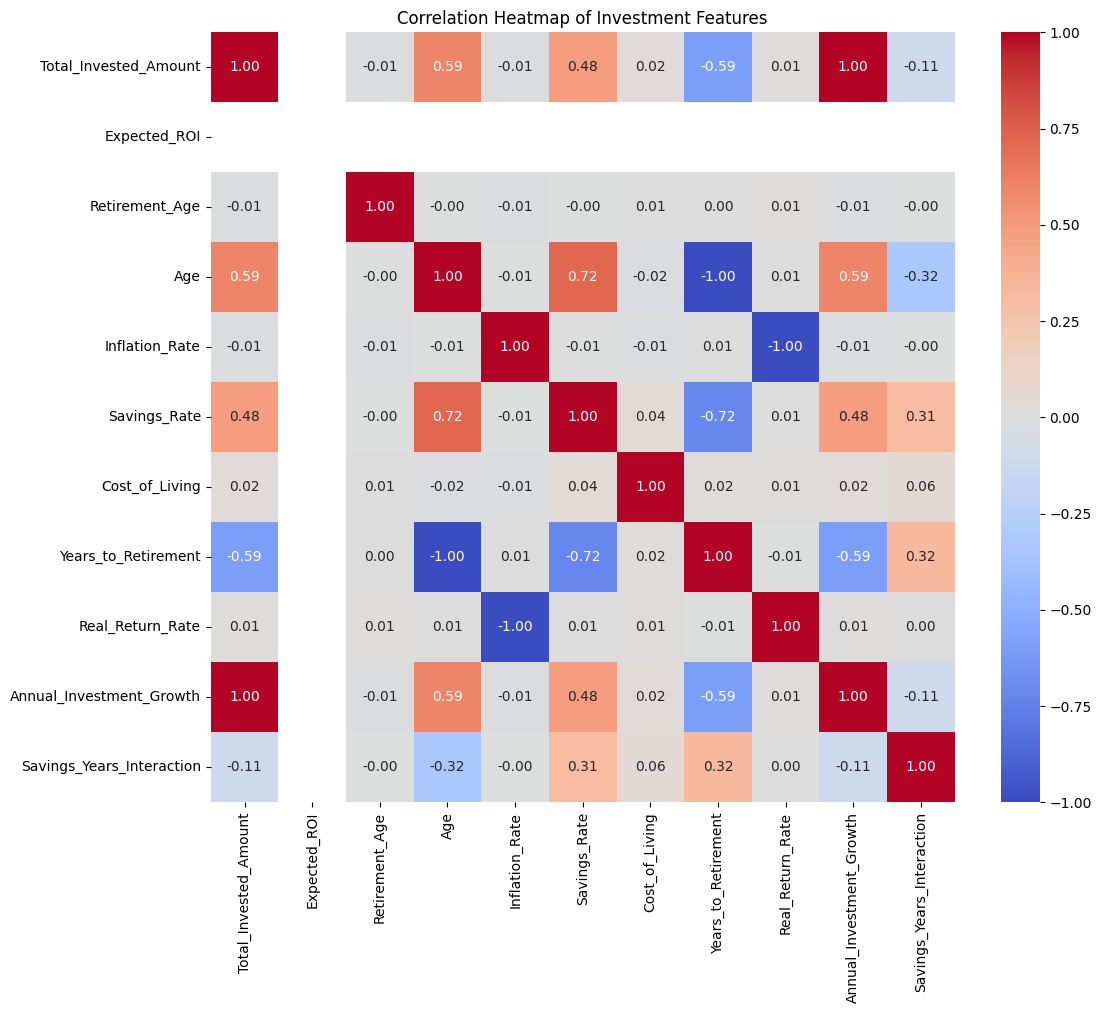

In [429]:
import seaborn as sns
subset_df = df[features]

# Calculate the correlation matrix
correlation_matrix = subset_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Investment Features')
plt.show()

### Insights
- `Annual_Investment_Growth`, `Expected_ROI`, `Real_Return_Rate` are highly correlated. We should drop two of them to prevent overfitting. Highly correlated features essentially provide the same information to the model. Including both features can introduce redundancy and doesn't significantly improve the model's ability to learn the underlying patterns in the data.
- Tree-based models (like decision trees and random forests) are `less sensitive` to highly correlated features than linear models. However, removing redundant features can still `improve` the model's `efficiency`.

In [430]:
# Feature selection
features = ['Total_Invested_Amount', 'Retirement_Age', 'Age', 'Inflation_Rate',
            'Savings_Rate', 'Cost_of_Living', 'Years_to_Retirement', 'Real_Return_Rate',
           'Savings_Years_Interaction']
target = 'Future_Investment_Value'

X = df[features]
y = df[target]

# Normalize features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=features)
joblib.dump(scaler, 'scaler.pkl')

# Train-test split (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

best_params = {
    'learning_rate': 0.01,
    'max_depth': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_estimators': 200,
    'subsample': 0.8,    # Subsampling for better generalization
    'colsample_bytree': 0.8,  # Feature fraction for each tree
}

# Train final model using LightGBM
best_lgb_model = lgb.LGBMRegressor(**best_params, objective='regression', random_state=42, n_jobs=-1)
best_lgb_model.fit(X_train, y_train)

# Evaluate model (remains the same)
y_pred = best_lgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results (remains the same)
print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'R^2 Score: {r2:.4f}')

Mean Squared Error: 57339228.7583
Mean Absolute Error: 804.4259
R^2 Score: 0.9361


## Hyperparameter Tuning with GridSearchCV

In [431]:
# Define the hyperparameters grid to search over
param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
}

# Initialize LightGBM model
lgb_model = lgb.LGBMRegressor(objective='regression', metric='rmse')

# Set up the GridSearchCV with cross-validation (use 5-fold cross-validation)
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters found
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

# Get the best model and make predictions on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the best model using MSE, MAE, and R²
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R² (R-squared): {r2}')


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'num_leaves': 31, 'subsample': 0.7}
Mean Squared Error (MSE): 37849592.40184364
Mean Absolute Error (MAE): 497.92689578287775
R² (R-squared): 0.9578004099028913


### Interpretation
- Best Parameters found using grid serach cv: 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'num_leaves': 31, 'subsample': 0.7

## Hyperparameter Tuning with RandomizedSearchCV

In [432]:
# Define the hyperparameters to sample
param_dist = {
    'num_leaves': [31, 50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500],
    'max_depth': [-1, 5, 10, 15],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=lgb_model, param_distributions=param_dist, n_iter=100, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1, random_state=42)

# Fit the model to the training data
random_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Make predictions and evaluate the model
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Best Parameters (RandomizedSearchCV): {best_params}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R² (R-squared): {r2}')


Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Best Parameters (RandomizedSearchCV): {'subsample': 0.8, 'num_leaves': 50, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Mean Squared Error (MSE): 36678354.38166989
Mean Absolute Error (MAE): 505.1355378856521
R² (R-squared): 0.9591062565770836


### Interpretation
- The best model is found using `randomized serach cv` with a r^2 value of `0.96` and the `lowest MSE` and a `MAE slightly higher` than the previous model (trained using the best parameters found using grid search).
- The model is trained on the follwing 9 features: `Total_Invested_Amount`, `Retirement_Age`, `Age`, `Inflation_Rate`, `Savings_Rate`, `Cost_of_Living`, `Years_to_Retirement`, `Real_Return_Rate`,`Savings_Years_Interaction`
- Best Parameters found using RandomizedSearchCV: subsample': 0.8, 'num_leaves': 50, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.7

## Save Model

In [ ]:
# Save model
joblib.dump(best_lgb_model, 'investment_lgb_model.pkl')

# Save model as JSON
best_lgb_model.booster_.save_model('investment_lgb_model.json')